<a href="https://colab.research.google.com/github/SeongminCC/private_project/blob/main/Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facebook Prophet
**ARIMA 보다 조금 더 정확한 트렌드 예측 분석을 함**

**Prophet은 Additive 모델이라는 모델링 방법에 기반한 시계열 예측 모델**
  - 시계열 데이터의 트렌드성(연간/월간/일간)을 예측하는 것에 초점이 맞추어져 있음
  - Additive 모델 : 선형 회귀 분석의 단점을 극복하기 위해 개량된 분석 방법의 하나
    - 시계열 분석 역시 회귀 분석의 한 갈래이기에 회귀분석의 단점을 가지고 있음
    - 이 단점을 극복하기 위해 각 피처마다 비선형적 적합을 가능하게 하는 일련의 방법을 적용함

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import warnings
from glob import glob
from sklearn.model_selection import train_test_split
import random
import os

# 경고 끄기
warnings.filterwarnings(action='ignore')

# 시드고정
random.seed(19970119)
np.random.seed(19970119)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/private project
!ls -al

/content/drive/MyDrive/private project
total 169
-rw------- 1 root root 164626 Sep  9 16:48  ARIMA.ipynb
drwx------ 2 root root   4096 Sep  9 15:14  data
-rw------- 1 root root   4068 Sep 10 14:30 'Facebook Prophet.ipynb'


# 데이터 불러오기
**2021/09/09 ~ 2022/09/09 까지의 비트코인 가격(USD) 데이터인 csv파일을 불러온다**

In [4]:
bitcoin_df = pd.read_csv('./data/bitcoin/bitcoin_20210909_20220909.csv')
bitcoin_df

,Timestamp,market-price
0,2021-09-09 00:00:00,46078.38
1,2021-09-10 00:00:00,46368.69
2,2021-09-11 00:00:00,44847.48
3,2021-09-12 00:00:00,45144.79
4,2021-09-13 00:00:00,46059.12
...,...,...
361,2022-09-05 00:00:00,19994.65
362,2022-09-06 00:00:00,19789.87
363,2022-09-07 00:00:00,18806.70
364,2022-09-08 00:00:00,19280.08


**데이터 전처리**

In [5]:
day_split = bitcoin_df['Timestamp'].str.split(" ")

In [6]:
bitcoin_df['Timestamp'] = day_split.str.get(0)
bitcoin_df.columns = ['datadate', 'price']
bitcoin_df

,datadate,price
0,2021-09-09,46078.38
1,2021-09-10,46368.69
2,2021-09-11,44847.48
3,2021-09-12,45144.79
4,2021-09-13,46059.12
...,...,...
361,2022-09-05,19994.65
362,2022-09-06,19789.87
363,2022-09-07,18806.70
364,2022-09-08,19280.08


**시계열 정보를 데이터 프레임의 인덱스로 설정**

In [7]:
bitcoin_df['datadate'] = pd.to_datetime(bitcoin_df['datadate'])
bitcoin_df.index = bitcoin_df['datadate']
bitcoin_df.set_index('datadate', inplace=True)
bitcoin_df

,price
datadate,
2021-09-09,46078.38
2021-09-10,46368.69
2021-09-11,44847.48
2021-09-12,45144.79
2021-09-13,46059.12
...,...
2022-09-05,19994.65
2022-09-06,19789.87
2022-09-07,18806.70


# train / test 데이터셋 나누기

In [8]:
bitcoin_df_train = bitcoin_df.iloc[:-5]
bitcoin_df_test = bitcoin_df.iloc[-5:]
bitcoin_df_test

,price
datadate,
2022-09-05,19994.65
2022-09-06,19789.87
2022-09-07,18806.70
2022-09-08,19280.08
2022-09-09,19327.53


# 가격 추이 시각화

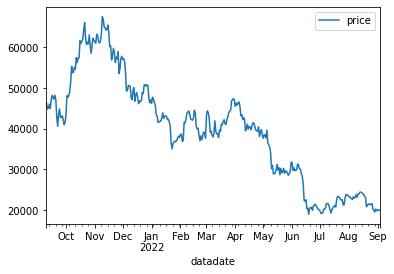

In [9]:
bitcoin_df_train.plot()
plt.show()

# fbprophet 라이브러리 설치

In [10]:
!pip install pystan==2.19.1.1 --quiet
!pip install fbprophet --quiet

     |████████████████████████████████| 67.3 MB 1.2 MB/s 
     |████████████████████████████████| 64 kB 1.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1 requires cmdstanpy>=1.0.1, but you have cmdstanpy 0.9.5 which is incompatible.


In [71]:
from fbprophet import Prophet

prophet모델에 사용할 수 있도록 데이터 프레임 수정

In [72]:
date = bitcoin_df.index.tolist()
df = pd.DataFrame(data = [date, bitcoin_df['price']]).T
df.columns = ['ds', 'y']
df.index = date
df

,ds,y
2021-09-09,2021-09-09,46078.38
2021-09-10,2021-09-10,46368.69
2021-09-11,2021-09-11,44847.48
2021-09-12,2021-09-12,45144.79
2021-09-13,2021-09-13,46059.12
...,...,...
2022-09-05,2022-09-05,19994.65
2022-09-06,2022-09-06,19789.87
2022-09-07,2022-09-07,18806.7
2022-09-08,2022-09-08,19280.08


In [73]:
df_train = df.iloc[:-5]
df_test = df.iloc[-5:]
df_test

,ds,y
2022-09-05,2022-09-05,19994.65
2022-09-06,2022-09-06,19789.87
2022-09-07,2022-09-07,18806.7
2022-09-08,2022-09-08,19280.08
2022-09-09,2022-09-09,19327.53


2022/09/05 ~ 2022/09/09 의 데이터는 train데이터에 존재하지 않지만 예측을 하여 값이 나온 것을 확인할 수 있다.

In [74]:
prophet = Prophet()  #프로펫 변수설정

prophet.fit(df_train) #프로펫을 학습시킨다.

future_data=prophet.make_future_dataframe(periods=5, freq = 'd')  # 5일치를 예측할 것.

forecast_data=prophet.predict(future_data)
forecast_data.tail(5)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
361,2022-09-05,21123.687612,17483.820841,24582.813496,21123.687612,21123.687612,-40.317204,-40.317204,-40.317204,-40.317204,-40.317204,-40.317204,0.0,0.0,0.0,21083.370408
362,2022-09-06,21102.219358,17737.775364,24612.960117,21102.219358,21102.219358,2.464369,2.464369,2.464369,2.464369,2.464369,2.464369,0.0,0.0,0.0,21104.683727
363,2022-09-07,21080.751104,17700.239425,24870.103038,21080.751104,21080.751104,126.117856,126.117856,126.117856,126.117856,126.117856,126.117856,0.0,0.0,0.0,21206.868960
364,2022-09-08,21059.282849,17993.714778,24851.191983,21048.944764,21067.450828,310.314062,310.314062,310.314062,310.314062,310.314062,310.314062,0.0,0.0,0.0,21369.596911
365,2022-09-09,21037.814595,17575.894040,24558.810222,21004.707048,21078.746913,39.100962,39.100962,39.100962,39.100962,39.100962,39.100962,0.0,0.0,0.0,21076.915557


# 모델 성능 확인

In [75]:
pred_y = forecast_data.yhat.values[-5:]  # 마지막 5일의 예측 데이터(2022/09/05 ~ 2022/09/09)
test_y = df_test.y.values  # 실제 5일 가격 데이터(2022/09/05 ~ 2022/09/09) 
pred_y_lower = forecast_data.yhat_lower.values[-5:]  # 마지막 5일 최대값
pred_y_upper = forecast_data.yhat_upper.values[-5:]  # 마지막 5일 최소값

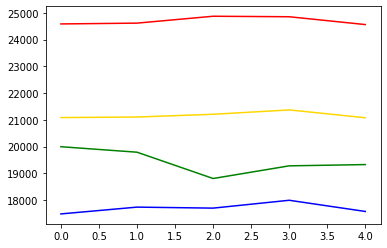

In [76]:
plt.plot(pred_y, color = 'gold')  # 모델이 예상한 가격
plt.plot(pred_y_upper, color = 'red')  # 모델이 예상한 최대 가격
plt.plot(pred_y_lower, color = 'blue')  # 모델이 예상한 최소 가격
plt.plot(test_y, color = 'green')  # 실제 가격
plt.show()


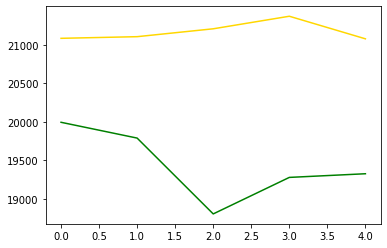

In [77]:
plt.plot(pred_y, color = 'gold')  # 모델이 예상한 가격
plt.plot(test_y, color = 'green')  # 실제 가격
plt.show()

In [78]:
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
import math

In [79]:
rmse = math.sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

1794.5076789262332


# 모델의 성능 향상
1. 상한값 or 하한값 설정
2. 이상치 제거 
  - 이상치 : 평균적인 수치에 비해 지나치게 높거나 낮은 수치의 데이터를 의미

# 상한가 및 하한가 설정

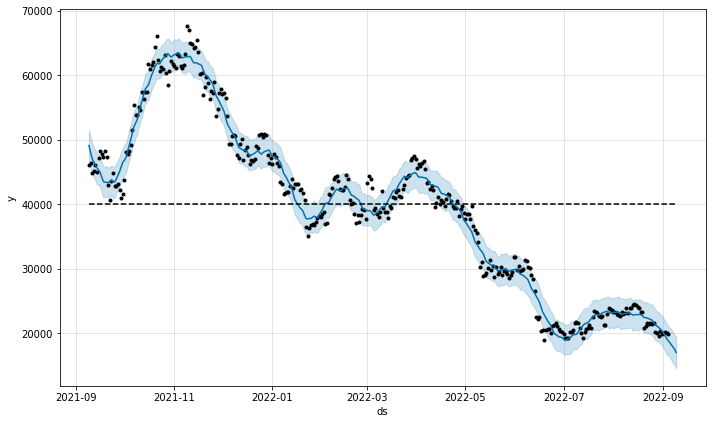

In [100]:
# 상한가 설정
df_train['cap'] = 40000

prophet = Prophet(seasonality_mode='multiplicative',
                  growth='logistic',  # 상한가 파라미터
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(df_train)

future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가 설정
future_data['cap'] = 40000
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

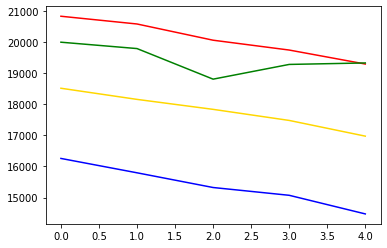

In [101]:
pred_y = forecast_data.yhat.values[-5:]  # 마지막 5일의 예측 데이터(2022/09/05 ~ 2022/09/09)
test_y = df_test.y.values  # 실제 5일 가격 데이터(2022/09/05 ~ 2022/09/09) 
pred_y_lower = forecast_data.yhat_lower.values[-5:]  # 마지막 5일 최대값
pred_y_upper = forecast_data.yhat_upper.values[-5:]  # 마지막 5일 최소값

plt.plot(pred_y, color = 'gold')  # 모델이 예상한 가격
plt.plot(pred_y_upper, color = 'red')  # 모델이 예상한 최대 가격
plt.plot(pred_y_lower, color = 'blue')  # 모델이 예상한 최소 가격
plt.plot(test_y, color = 'green')  # 실제 가격
plt.show()

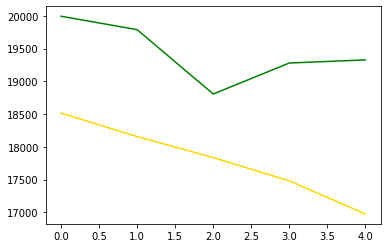

In [102]:
plt.plot(pred_y, color = 'gold')  # 모델이 예상한 가격
plt.plot(test_y, color = 'green')  # 실제 가격
plt.show()

# 이상치 제거

In [103]:
# 상한가 column 제거
df_train = df_train.drop(['cap'], axis=1)

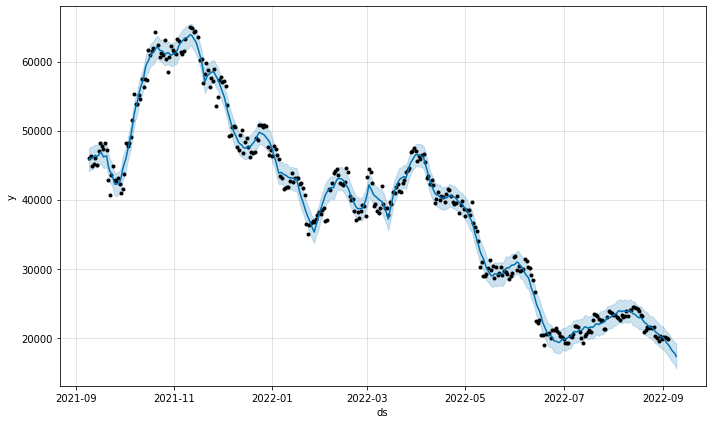

In [105]:
# 65000 이상의 데이터는 이상치로 판단
df_train.loc[df_train['y'] > 65000, 'y'] = None

# prophet 모델 학습
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(df_train)

future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측한 결과 그래프 출력
fig = prophet.plot(forecast_data)

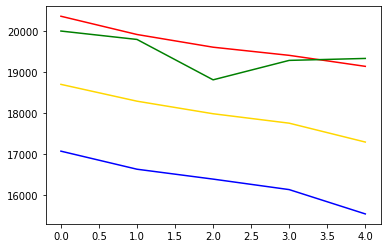

In [106]:
pred_y = forecast_data.yhat.values[-5:]  # 마지막 5일의 예측 데이터(2022/09/05 ~ 2022/09/09)
test_y = df_test.y.values  # 실제 5일 가격 데이터(2022/09/05 ~ 2022/09/09) 
pred_y_lower = forecast_data.yhat_lower.values[-5:]  # 마지막 5일 최대값
pred_y_upper = forecast_data.yhat_upper.values[-5:]  # 마지막 5일 최소값

plt.plot(pred_y, color = 'gold')  # 모델이 예상한 가격
plt.plot(pred_y_upper, color = 'red')  # 모델이 예상한 최대 가격
plt.plot(pred_y_lower, color = 'blue')  # 모델이 예상한 최소 가격
plt.plot(test_y, color = 'green')  # 실제 가격
plt.show()

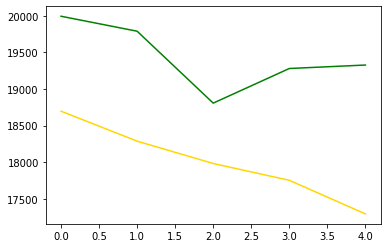

In [107]:
plt.plot(pred_y, color = 'gold')  # 모델이 예상한 가격
plt.plot(test_y, color = 'green')  # 실제 가격
plt.show()